In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score , confusion_matrix ,classification_report, precision_score,recall_score,f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model, tree, ensemble
from sklearn.svm import SVC
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("heart_failure_clinical_records1.csv")
df.head()

Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0

In [3]:
df.shape

(918, 12)

In [4]:
df.describe()

Age   RestingBP  Cholesterol   FastingBS       MaxHR  \
count  918.000000  918.000000   918.000000  918.000000  918.000000   
mean    53.510893  132.396514   198.799564    0.233115  136.809368   
std      9.432617   18.514154   109.384145    0.423046   25.460334   
min     28.000000    0.000000     0.000000    0.000000   60.000000   
25%     47.000000  120.000000   173.250000    0.000000  120.000000   
50%     54.000000  130.000000   223.000000    0.000000  138.000000   
75%     60.000000  140.000000   267.000000    0.000000  156.000000   
max     77.000000  200.000000   603.000000    1.000000  202.000000   

          Oldpeak  HeartDisease  
count  918.000000    918.000000  
mean     0.887364      0.553377  
std      1.066570      0.497414  
min     -2.600000      0.000000  
25%      0.000000      0.000000  
50%      0.600000      1.000000  
75%      1.500000      1.000000  
max      6.200000      1.000000

In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [6]:
df_cols = df.columns
df_cols

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

In [7]:
df.notnull().sum()

Age               918
Sex               918
ChestPainType     918
RestingBP         918
Cholesterol       918
FastingBS         918
RestingECG        918
MaxHR             918
ExerciseAngina    918
Oldpeak           918
ST_Slope          918
HeartDisease      918
dtype: int64

In [8]:
for column in df.select_dtypes(include=['object']).columns:
    num_unique_values = df[column].nunique()
    print(f"Number of distinct values in {column}: {num_unique_values}")

Number of distinct values in Sex: 2
Number of distinct values in ChestPainType: 4
Number of distinct values in RestingECG: 3
Number of distinct values in ExerciseAngina: 2
Number of distinct values in ST_Slope: 3


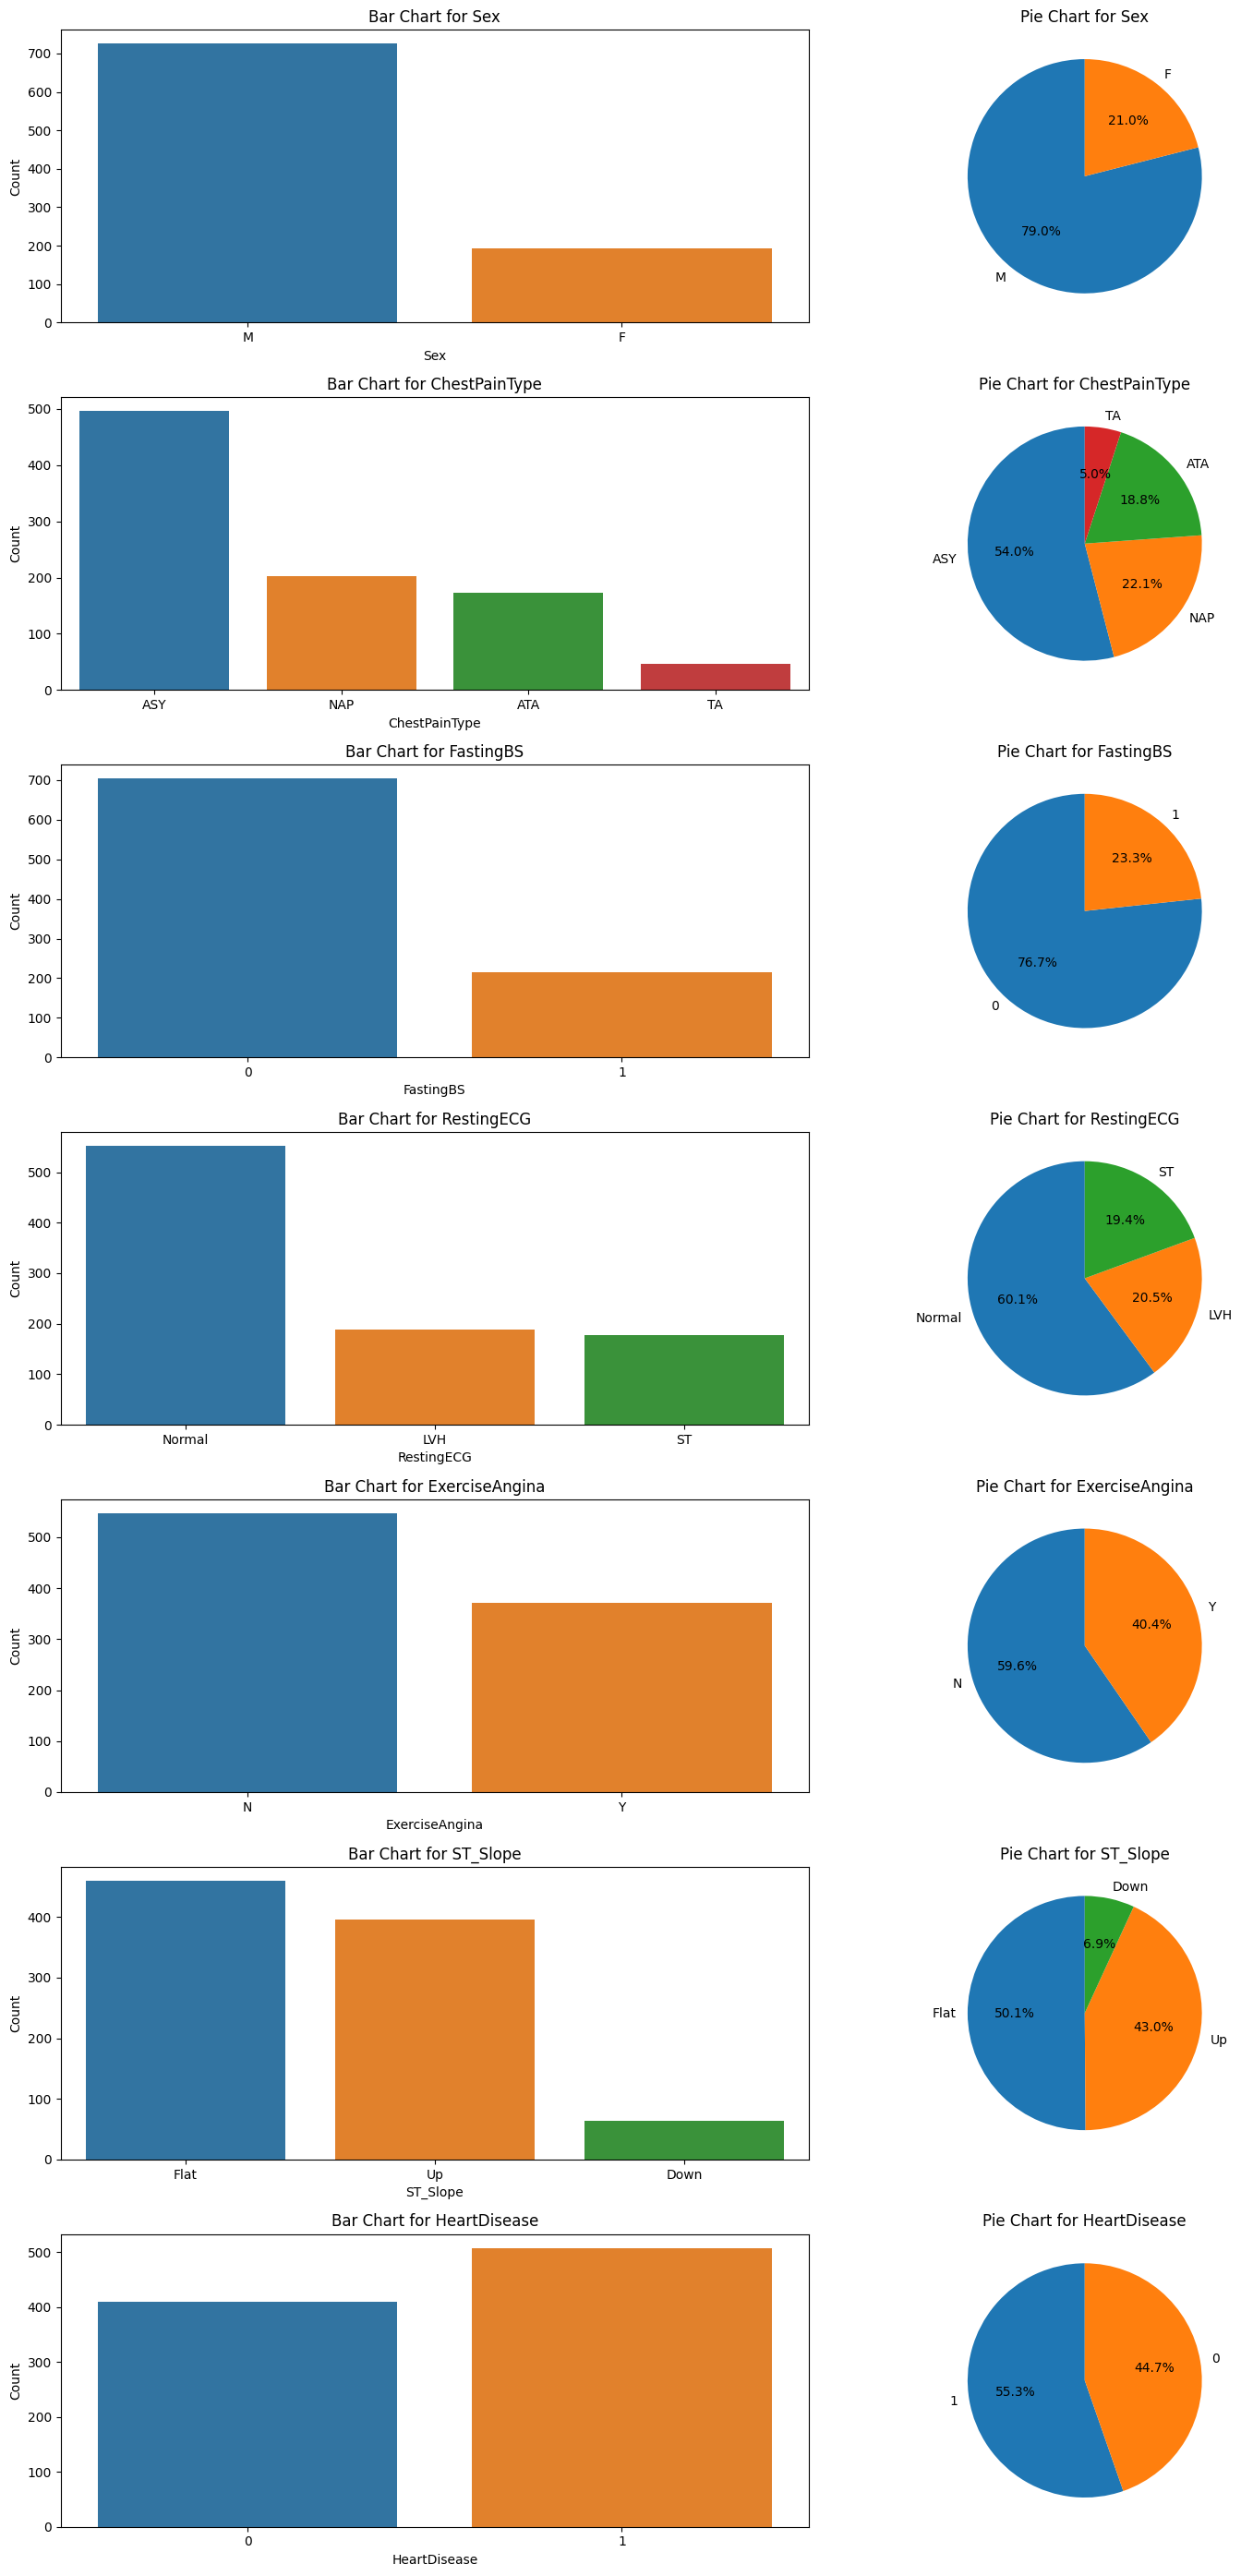

In [9]:
df_cat = df[[obj for obj in df.columns if df[obj].dtype =='object' or obj == 'HeartDisease' or obj == 'FastingBS']]

df_cat

fig, axes = plt.subplots(df_cat.shape[1], 2, figsize=(16, 4 * df_cat.shape[1]))
for i, column in enumerate(df_cat.columns):
    value_counts = df_cat[column].value_counts()
    count = value_counts.values
    labels = value_counts.index

    # Bar chart
    sns.barplot(x=labels, y=count, orient='v', ax=axes[i, 0])
    sns.barplot()
    axes[i, 0].set_title(f'Bar Chart for {column}')
    axes[i, 0].set_xlabel(column)
    axes[i, 0].set_ylabel('Count')

    # Pie chart
    axes[i, 1].pie(count, labels=labels, autopct='%1.1f%%', startangle=90)
    axes[i, 1].set_title(f'Pie Chart for {column}')

fig.tight_layout()
plt.show()

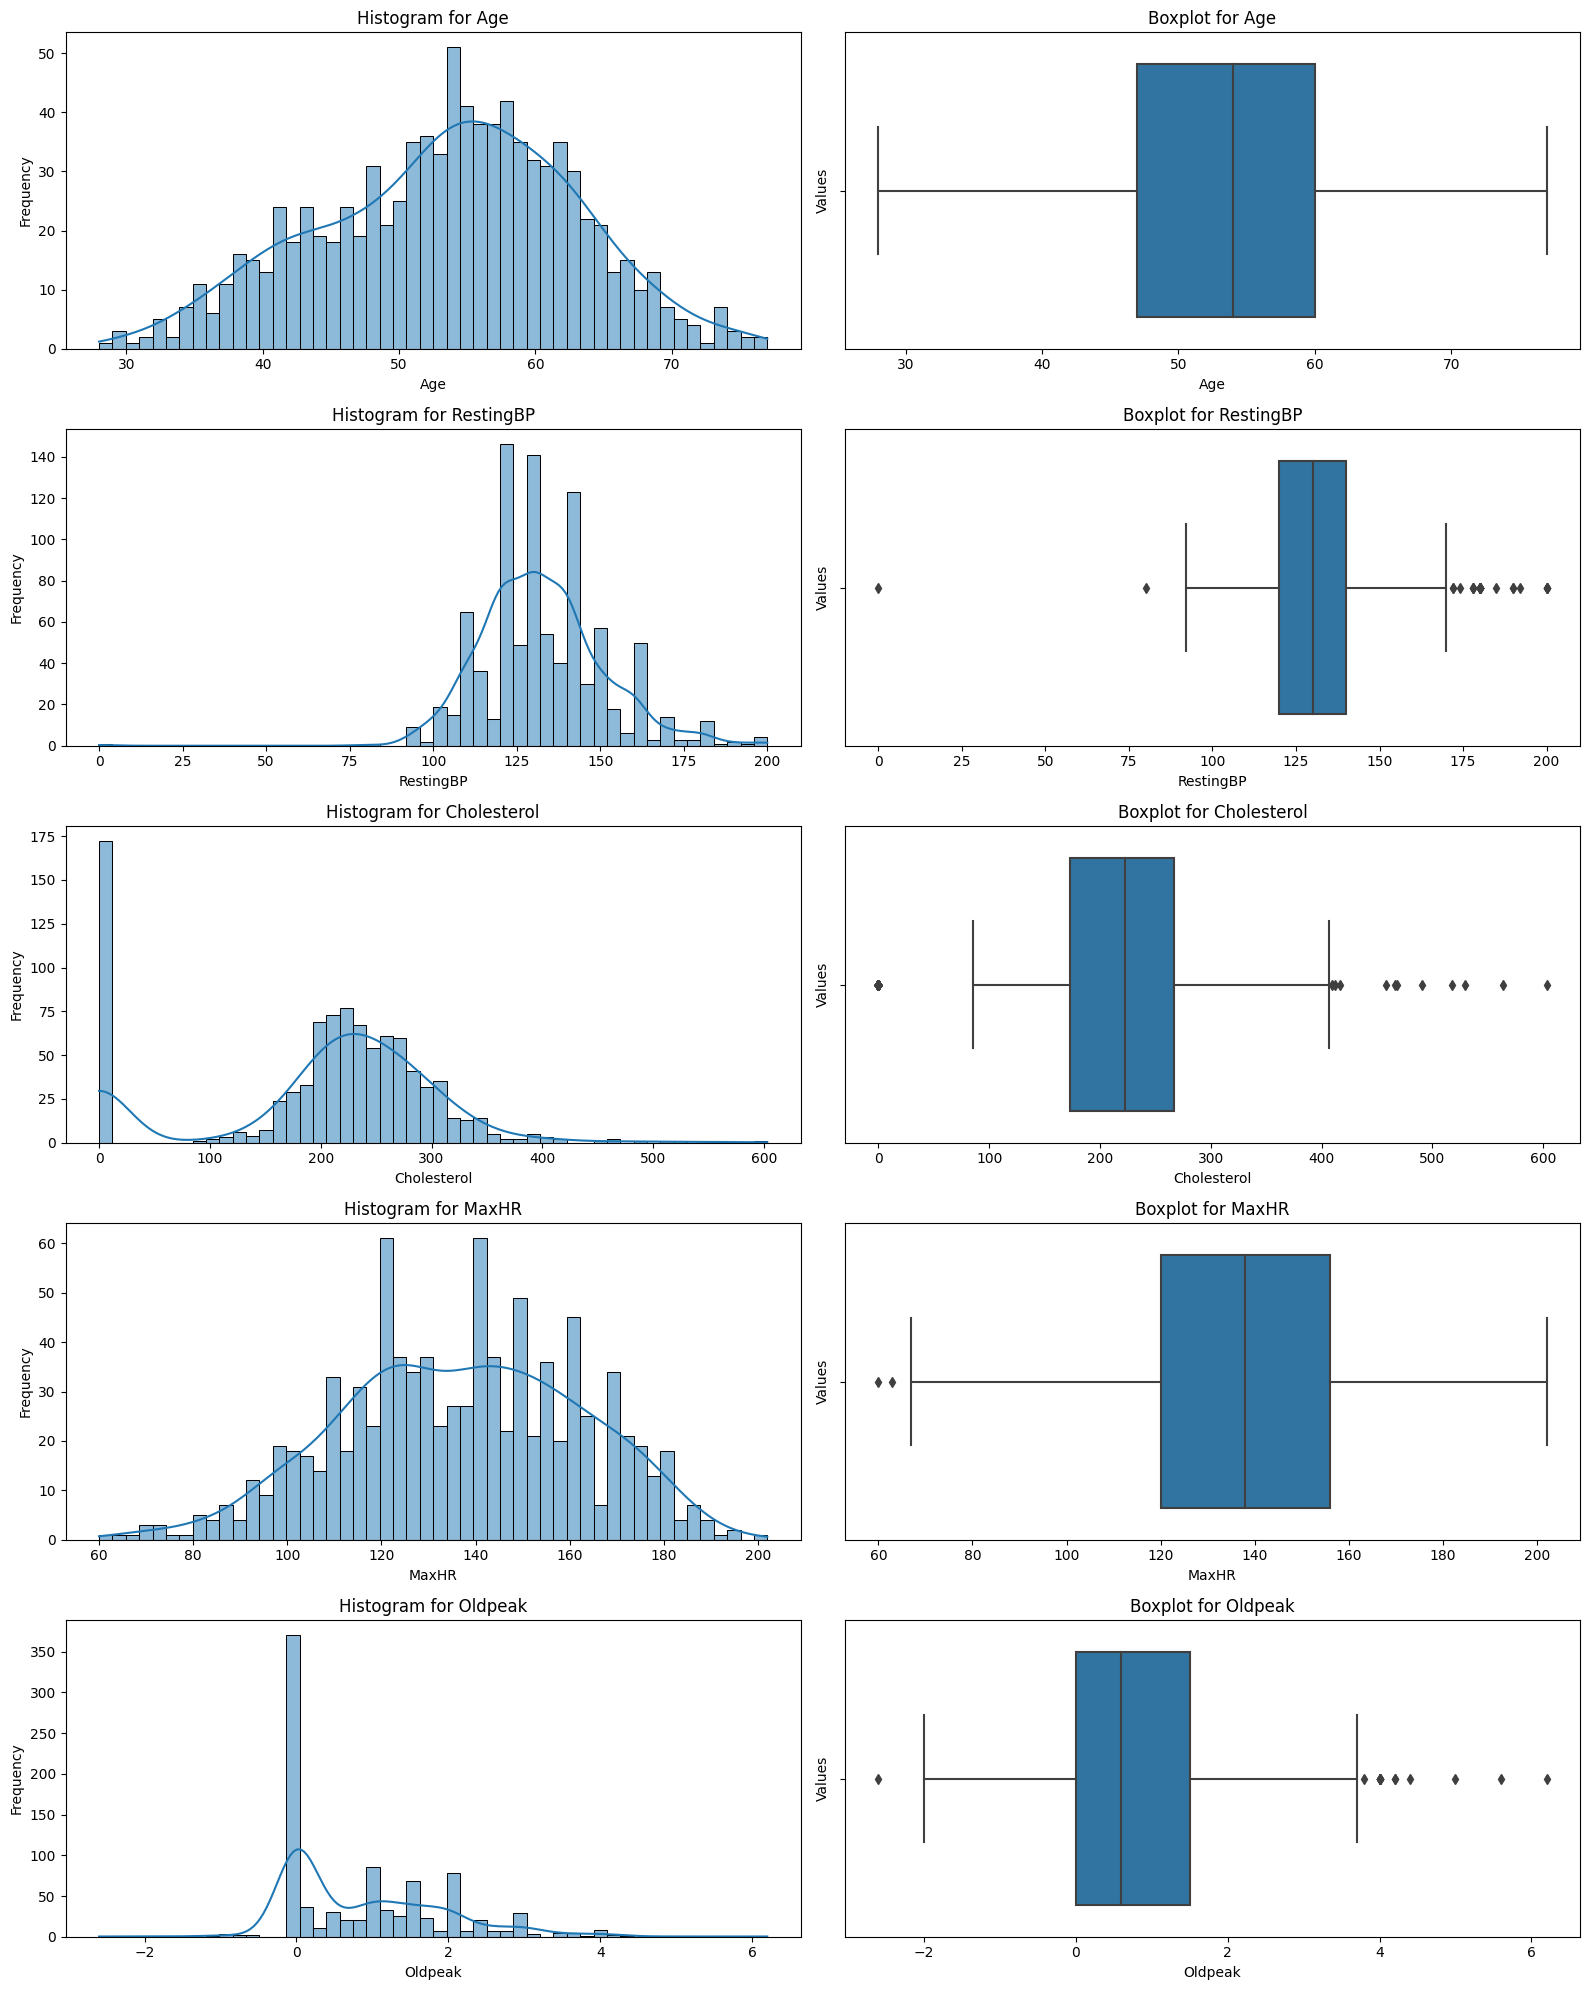

In [10]:
df_num = df[[obj for obj in df.select_dtypes(exclude=['object']).columns 
             if obj != 'HeartDisease' and obj != 'FastingBS' ]]
df_num


fig, axes = plt.subplots(df_num.shape[1], 2, figsize=(16, 4 * df_num.shape[1]))

for i, column in enumerate(df_num.columns):
    # Histogram
    sns.histplot(x=df_num[column], bins=50, kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Histogram for {column}')
    axes[i, 0].set_xlabel(column)
    axes[i, 0].set_ylabel('Frequency')

    # Boxplot
    sns.boxplot(x=df_num[column], ax=axes[i, 1])
    axes[i, 1].set_title(f'Boxplot for {column}')
    axes[i, 1].set_xlabel(column)
    axes[i, 1].set_ylabel('Values')

fig.tight_layout()
plt.show()

In [11]:
def handle_outliers(column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    low_bound = Q1 - 1.5 * IQR
    high_bound = Q3 + 1.5 * IQR
    return df[column].clip(lower=low_bound, upper=high_bound)

for column in df_num:
    df[column] = handle_outliers(column)

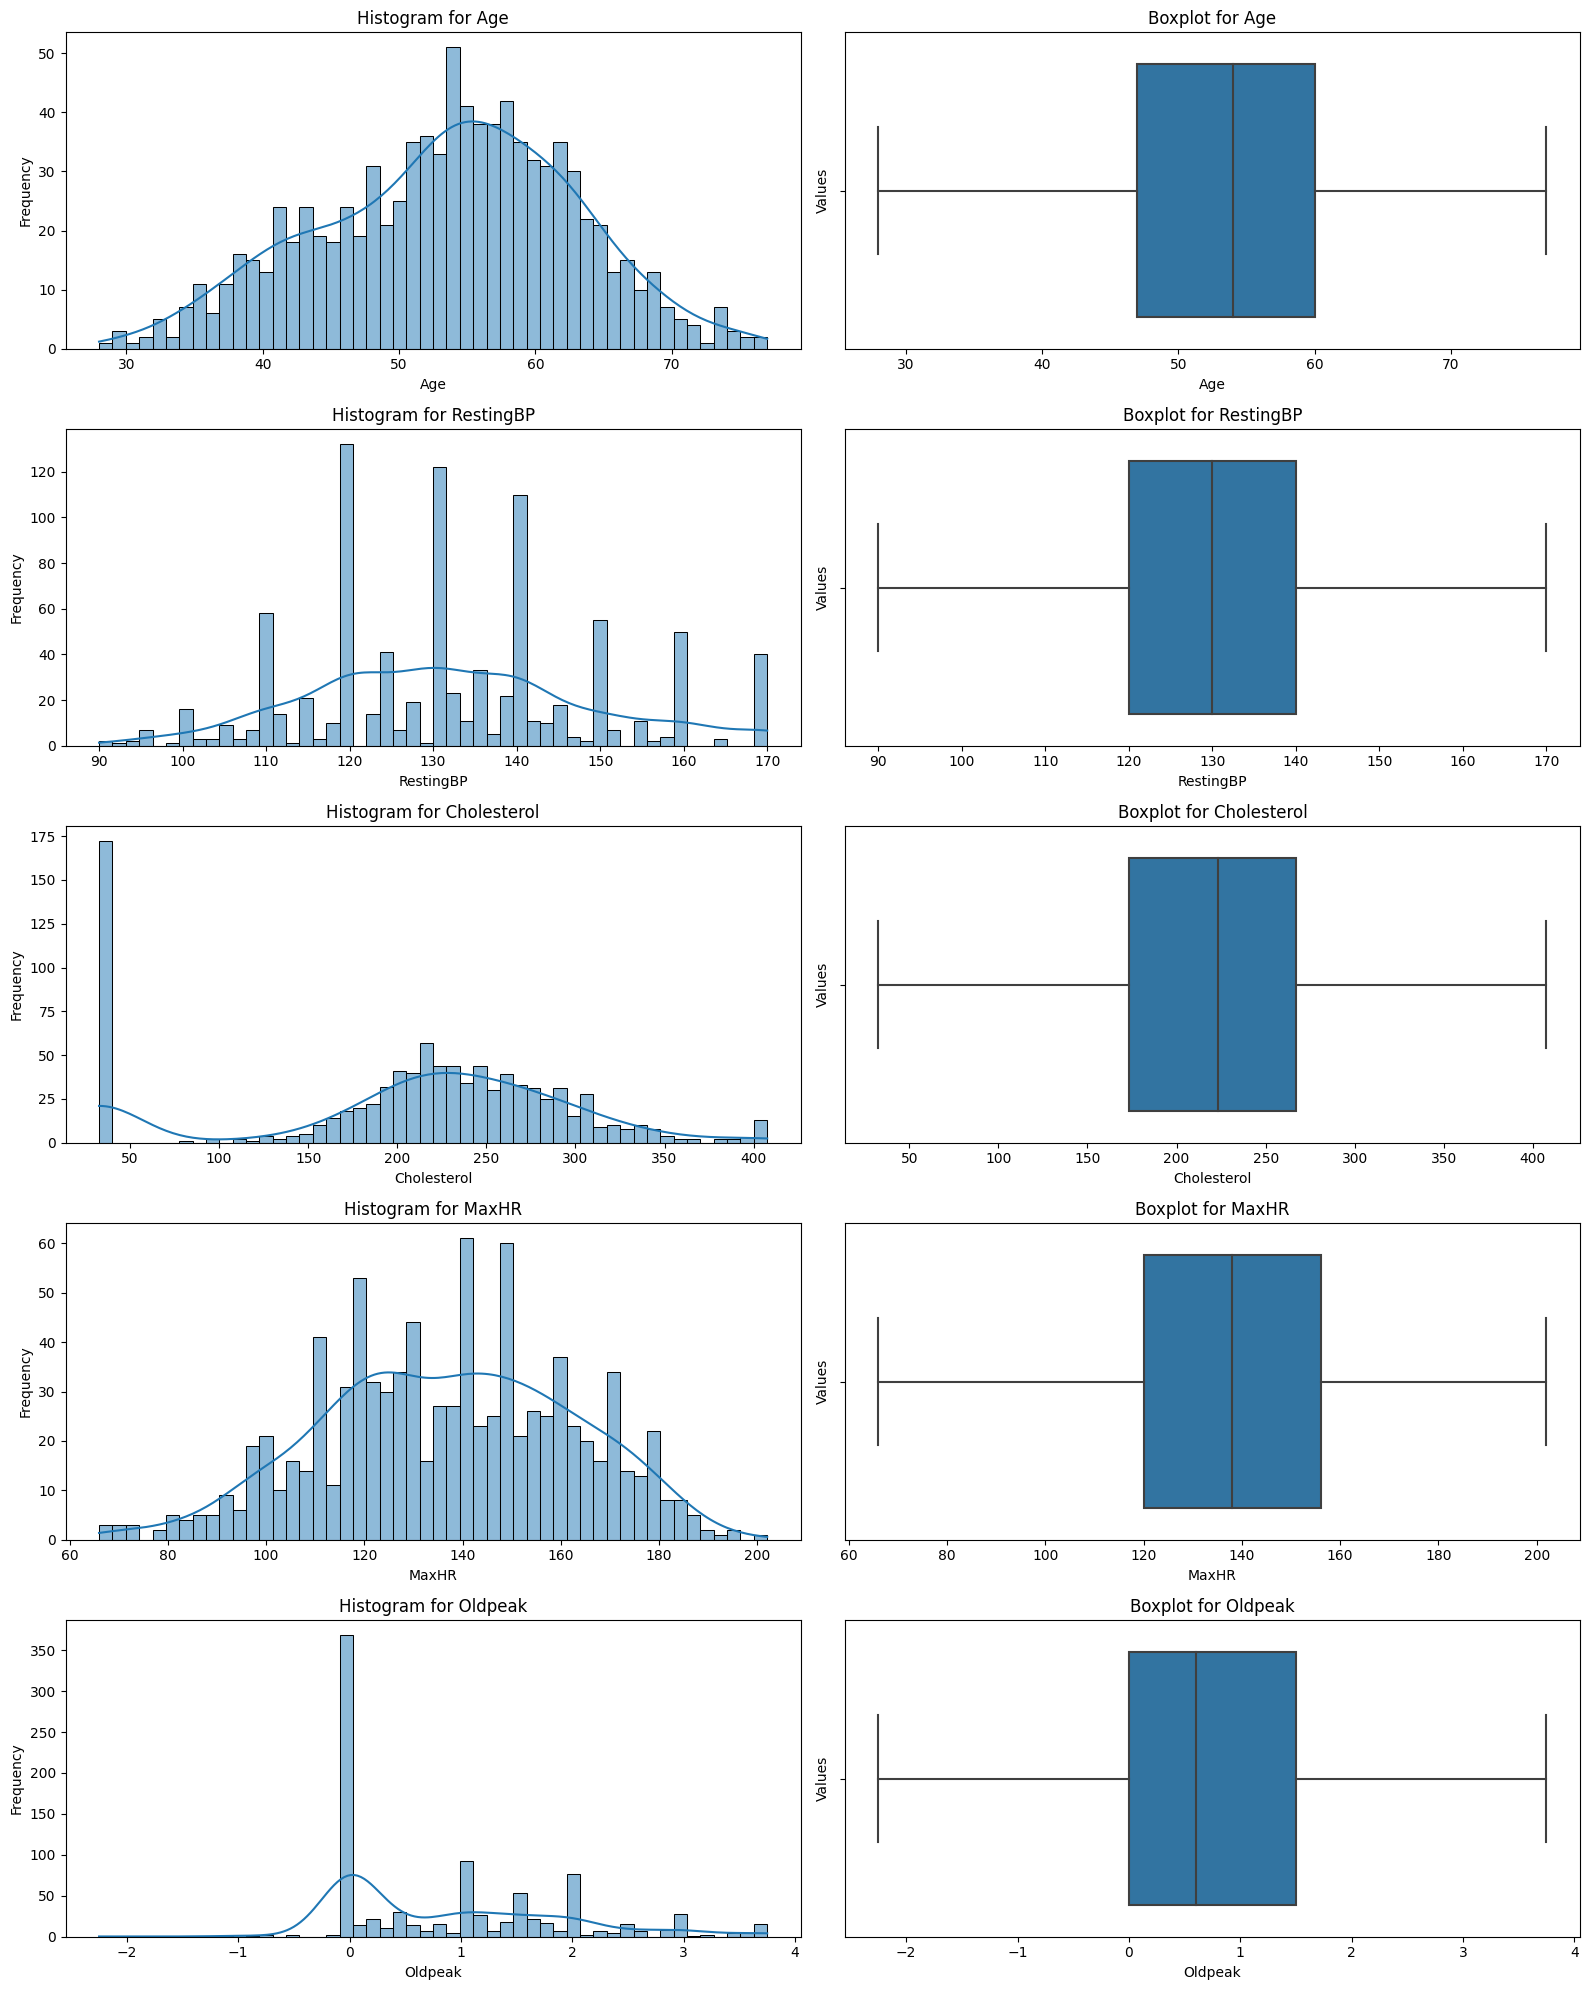

In [12]:
df_num1 = df[[obj for obj in df.select_dtypes(exclude=['object']).columns 
             if obj != 'HeartDisease' and obj != 'FastingBS' ]]
df_num1


fig, axes = plt.subplots(df_num1.shape[1], 2, figsize=(16, 4 * df_num1.shape[1]))

for i, column in enumerate(df_num1.columns):
    # Histogram
    sns.histplot(x=df_num1[column], bins=50, kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Histogram for {column}')
    axes[i, 0].set_xlabel(column)
    axes[i, 0].set_ylabel('Frequency')

    # Boxplot
    sns.boxplot(x=df_num1[column], ax=axes[i, 1])
    axes[i, 1].set_title(f'Boxplot for {column}')
    axes[i, 1].set_xlabel(column)
    axes[i, 1].set_ylabel('Values')

fig.tight_layout()
plt.show()

In [13]:
df_encoded = pd.get_dummies(df, columns=['Sex','ChestPainType','RestingECG','ExerciseAngina','ST_Slope'], prefix='Category',dtype='int')
df_encoded

Age  RestingBP  Cholesterol  FastingBS  MaxHR  Oldpeak  HeartDisease  \
0     40        140        289.0          0    172      0.0             0   
1     49        160        180.0          0    156      1.0             1   
2     37        130        283.0          0     98      0.0             0   
3     48        138        214.0          0    108      1.5             1   
4     54        150        195.0          0    122      0.0             0   
..   ...        ...          ...        ...    ...      ...           ...   
913   45        110        264.0          0    132      1.2             1   
914   68        144        193.0          1    141      3.4             1   
915   57        130        131.0          0    115      1.2             1   
916   57        130        236.0          0    174      0.0             1   
917   38        138        175.0          0    173      0.0             0   

     Category_F  Category_M  Category_ASY  ...  Category_NAP  Category_TA  \
0             0           1             0  ...             0            0   
1             1           0             0  ...             1            0   
2             0           1             0  ...             0            0   
3             1           0             1  ...             0            0   
4             0           1             0  ...             1            0   
..          ...         ...           ...  ...           ...          ...   
913           0           1             0  ...             0            1   
914           0           1             1  ...             0            0   
915           0           1             1  ...             0            0   
916           1           0             0  ...             0            0   
917           0           1             0  ...             1            0   

     Category_LVH  Category_Normal  Category_ST  Category_N  Category_Y  \
0               0                1            0           1           0   
1               0                1            0           1           0   
2               0                0            1           1           0   
3               0                1            0           0           1   
4               0                1            0           1           0   
..            ...              ...          ...         ...         ...   
913             0                1            0           1           0   
914             0                1            0           1           0   
915             0                1            0           0           1   
916             1                0            0           1           0   
917             0                1            0           1           0   

     Category_Down  Category_Flat  Category_Up  
0                0              0            1  
1                0              1            0  
2                0              0            1  
3                0              1            0  
4                0              0            1  
..             ...            ...          ...  
913              0              1            0  
914              0              1            0  
915              0              1            0  
916              0              1            0  
917              0              0            1  

[918 rows x 21 columns]

In [14]:
df_encoded.shape

(918, 21)

In [15]:
df_corr=df_encoded.corr()
df_corr

Age  RestingBP  Cholesterol  FastingBS     MaxHR  \
Age              1.000000   0.269950    -0.088063   0.198039 -0.382449   
RestingBP        0.269950   1.000000     0.107313   0.065864 -0.112972   
Cholesterol     -0.088063   0.107313     1.000000  -0.257816  0.232736   
FastingBS        0.198039   0.065864    -0.257816   1.000000 -0.131797   
MaxHR           -0.382449  -0.112972     0.232736  -0.131797  1.000000   
Oldpeak          0.262563   0.174454     0.054023   0.059230 -0.164927   
HeartDisease     0.282039   0.113191    -0.225304   0.267291 -0.400519   
Category_F      -0.055750  -0.016555     0.203929  -0.120076  0.189197   
Category_M       0.055750   0.016555    -0.203929   0.120076 -0.189197   
Category_ASY     0.166607   0.045155    -0.114099   0.131176 -0.355002   
Category_ATA    -0.218165  -0.054396     0.150955  -0.140514  0.253832   
Category_NAP    -0.011335  -0.032212    -0.013576  -0.039249  0.134524   
Category_TA      0.032042   0.055632     0.015875   0.026885  0.100048   
Category_LVH     0.145727   0.050454     0.180797  -0.011656  0.125738   
Category_Normal -0.230566  -0.115687    -0.045158  -0.093028  0.024142   
Category_ST      0.136798   0.091774    -0.128619   0.127110 -0.158244   
Category_N      -0.215793  -0.155341     0.025959  -0.060451  0.370892   
Category_Y       0.215793   0.155341    -0.025959   0.060451 -0.370892   
Category_Down    0.138397  -0.016463    -0.082693   0.105102 -0.073502   
Category_Flat    0.185568   0.111007    -0.050235   0.107006 -0.342834   
Category_Up     -0.258067  -0.103696     0.092955  -0.161730  0.383747   

                  Oldpeak  HeartDisease  Category_F  Category_M  Category_ASY  \
Age              0.262563      0.282039   -0.055750    0.055750      0.166607   
RestingBP        0.174454      0.113191   -0.016555    0.016555      0.045155   
Cholesterol      0.054023     -0.225304    0.203929   -0.203929     -0.114099   
FastingBS        0.059230      0.267291   -0.120076    0.120076      0.131176   
MaxHR           -0.164927     -0.400519    0.189197   -0.189197     -0.355002   
Oldpeak          1.000000      0.410211   -0.112159    0.112159      0.281977   
HeartDisease     0.410211      1.000000   -0.305445    0.305445      0.516716   
Category_F      -0.112159     -0.305445    1.000000   -1.000000     -0.183876   
Category_M       0.112159      0.305445   -1.000000    1.000000      0.183876   
Category_ASY     0.281977      0.516716   -0.183876    0.183876      1.000000   
Category_ATA    -0.266506     -0.401924    0.161522   -0.161522     -0.522432   
Category_NAP    -0.104849     -0.212964    0.066486   -0.066486     -0.577670   
Category_TA      0.033035     -0.054790    0.004031   -0.004031     -0.249003   
Category_LVH     0.084891      0.010670    0.049518   -0.049518      0.002289   
Category_Normal -0.115397     -0.091580    0.010634   -0.010634     -0.063606   
Category_ST      0.056264      0.102527   -0.063715    0.063715      0.076438   
Category_N      -0.418709     -0.494282    0.190664   -0.190664     -0.430034   
Category_Y       0.418709      0.494282   -0.190664    0.190664      0.430034   
Category_Down    0.307755      0.122527   -0.066036    0.066036      0.103407   
Category_Flat    0.298174      0.554134   -0.116077    0.116077      0.303645   
Category_Up     -0.458263     -0.622164    0.150942   -0.150942     -0.359443   

                 ...  Category_NAP  Category_TA  Category_LVH  \
Age              ...     -0.011335     0.032042      0.145727   
RestingBP        ...     -0.032212     0.055632      0.050454   
Cholesterol      ...     -0.013576     0.015875      0.180797   
FastingBS        ...     -0.039249     0.026885     -0.011656   
MaxHR            ...      0.134524     0.100048      0.125738   
Oldpeak          ...     -0.104849     0.033035      0.084891   
HeartDisease     ...     -0.212964    -0.054790      0.010670   
Category_F       ...      0.066486     0.004031      0.049518   
Category_M       ...     

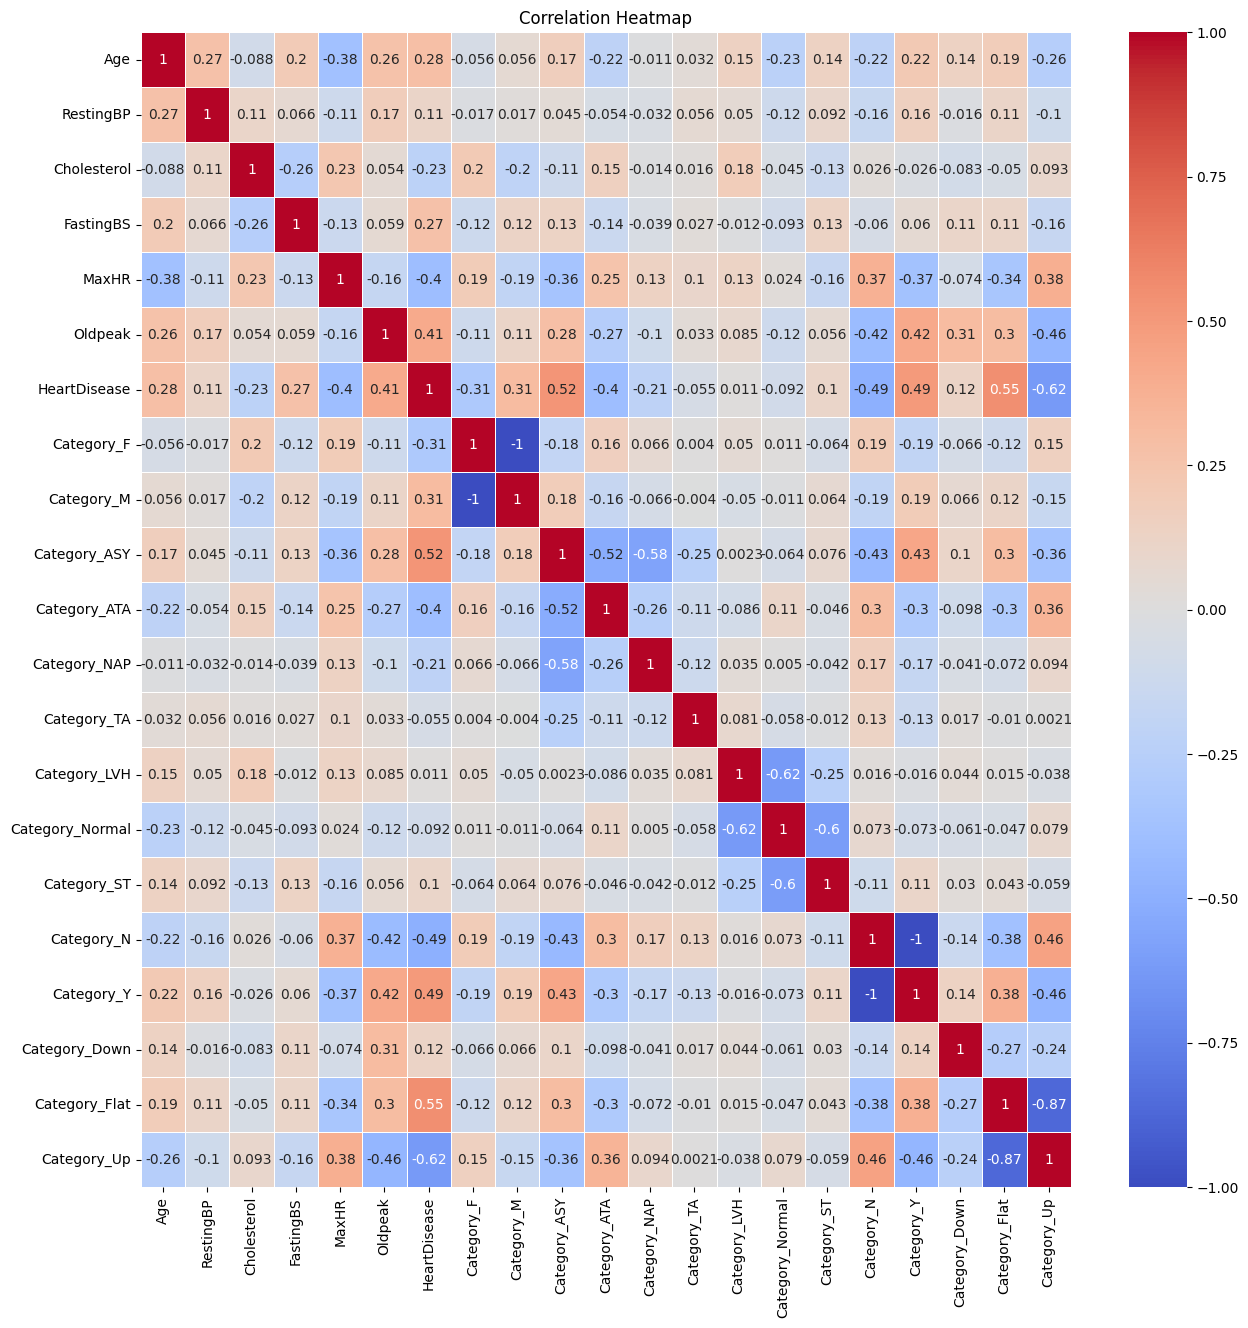

In [16]:
plt.figure(figsize=(15, 15))
sns.heatmap(df_corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

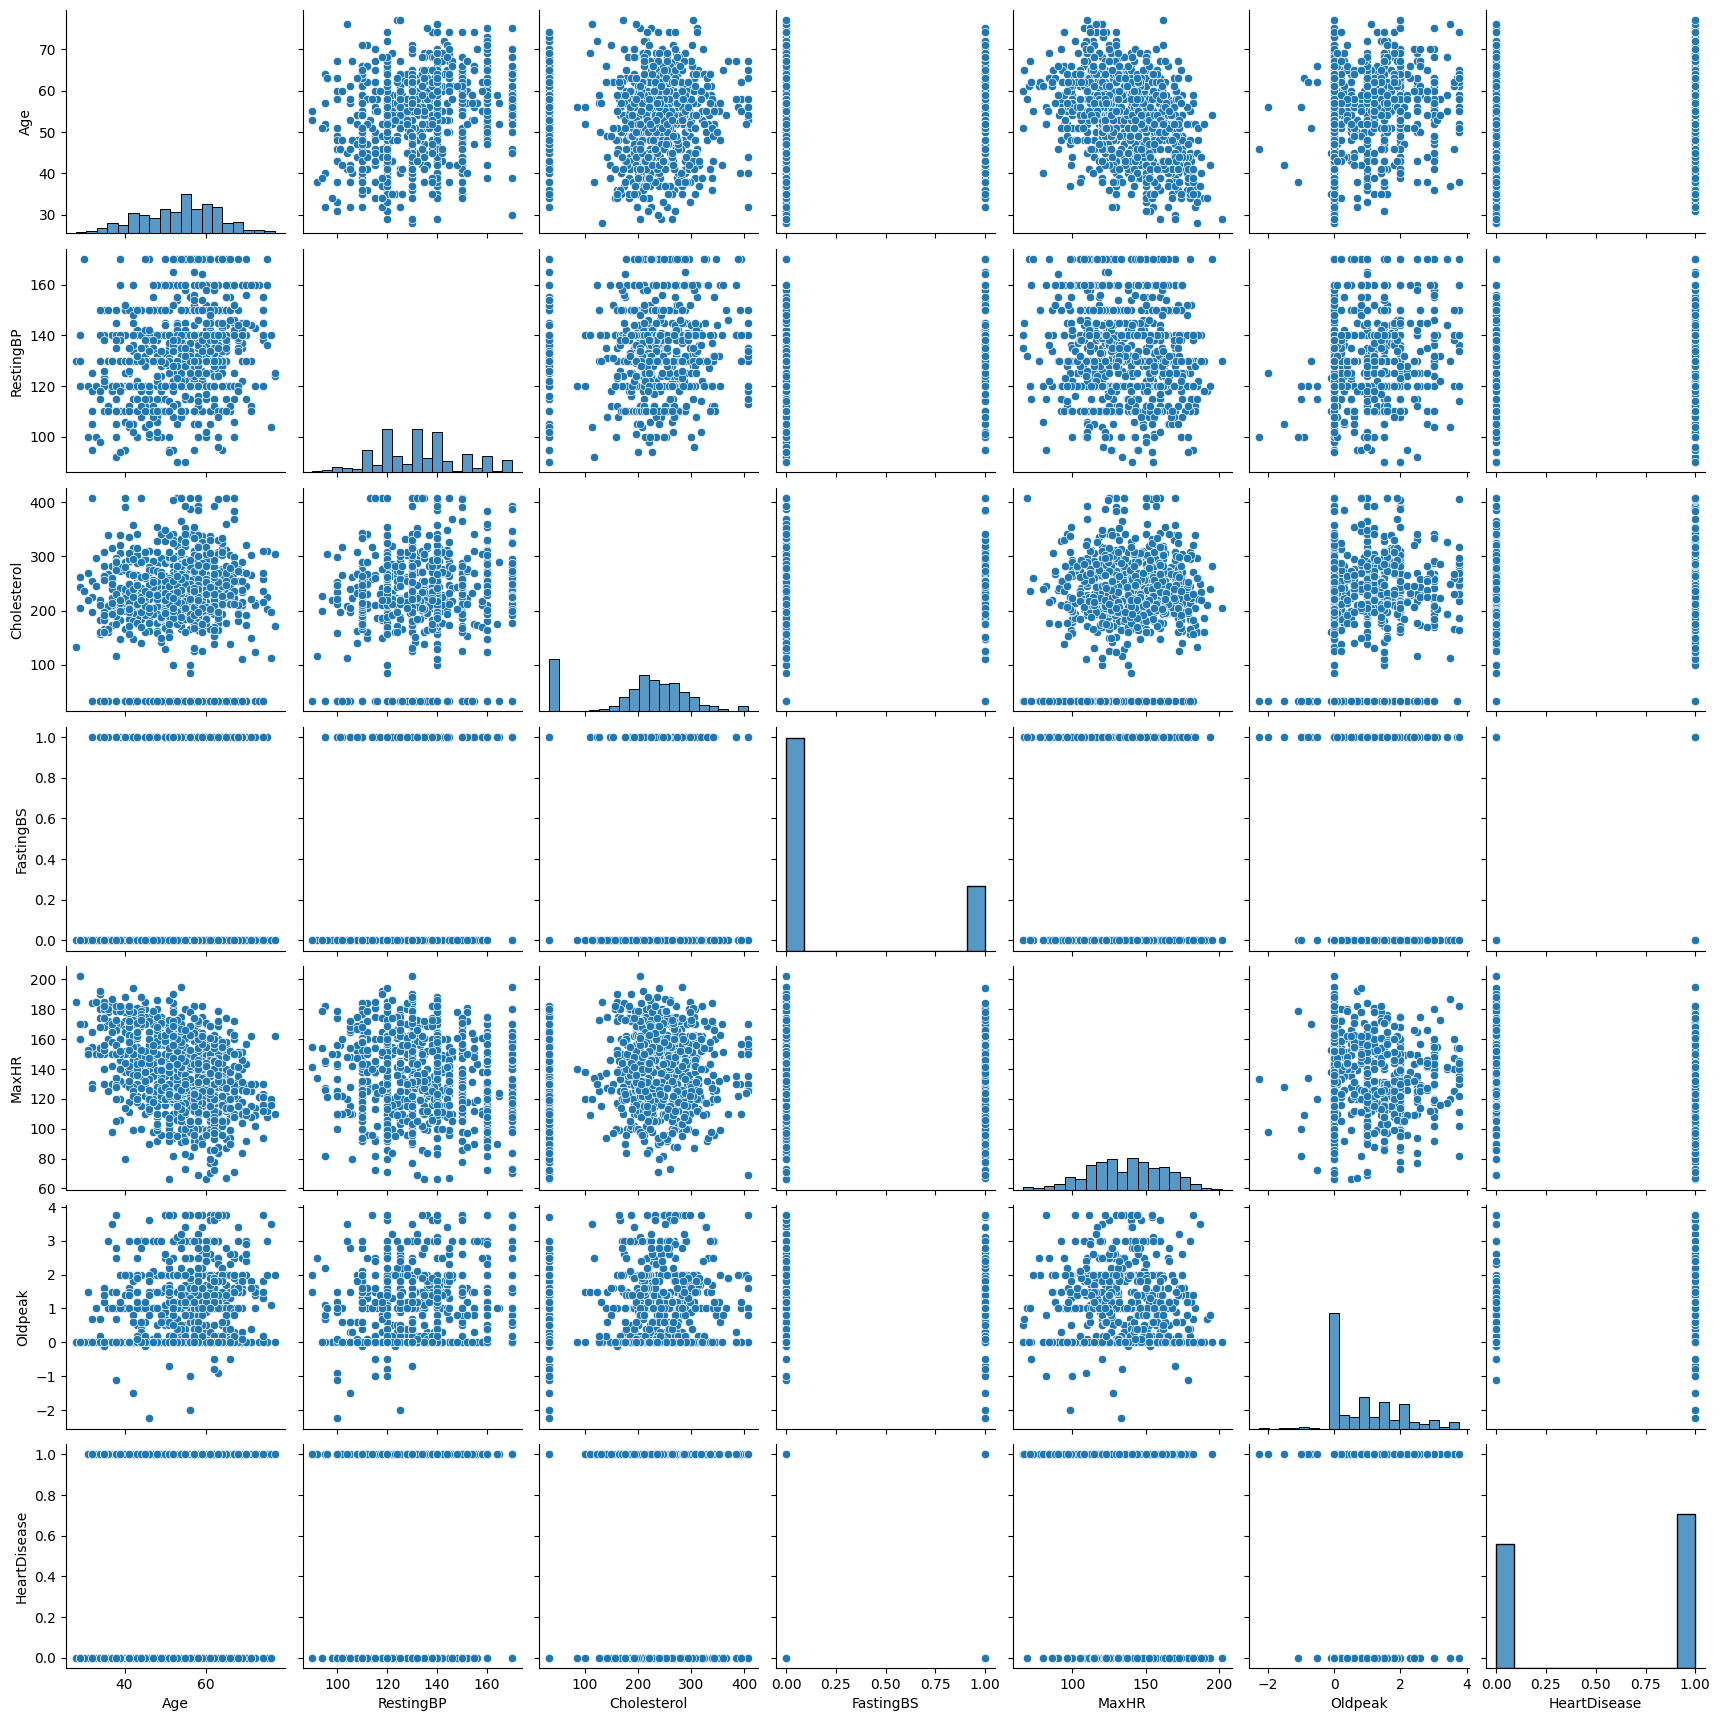

In [17]:
sns.pairplot(df)
plt.show()

In [18]:
X = df_encoded.drop('HeartDisease', axis=1)
Y = df_encoded['HeartDisease']

In [19]:
X.head(3)

Age  RestingBP  Cholesterol  FastingBS  MaxHR  Oldpeak  Category_F  \
0   40        140        289.0          0    172      0.0           0   
1   49        160        180.0          0    156      1.0           1   
2   37        130        283.0          0     98      0.0           0   

   Category_M  Category_ASY  Category_ATA  Category_NAP  Category_TA  \
0           1             0             1             0            0   
1           0             0             0             1            0   
2           1             0             1             0            0   

   Category_LVH  Category_Normal  Category_ST  Category_N  Category_Y  \
0             0                1            0           1           0   
1             0                1            0           1           0   
2             0                0            1           1           0   

   Category_Down  Category_Flat  Category_Up  
0              0              0            1  
1              0              1            0  
2              0              0            1

In [20]:
Y.head(3)

0    0
1    1
2    0
Name: HeartDisease, dtype: int64

# MODELLING

# Logistic Regression

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size=0.3,random_state=1)
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logmodel = LogisticRegression()

In [22]:
logmodel.fit(X_train,Y_train)

LogisticRegression()

In [23]:
predictions=logmodel.predict(X_test)

In [24]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test,predictions)

array([[ 98,  11],
       [ 21, 146]])

In [25]:
from sklearn.metrics import accuracy_score
accuracy_score(Y_test, predictions)

0.8840579710144928

Let's try standardization technique

In [26]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [27]:
logModelScaled = LogisticRegression()

In [28]:
logModelScaled.fit(X_train_scaled, Y_train)

LogisticRegression()

In [29]:
logModelScaled.score(X_test_scaled, Y_test)

0.8659420289855072

using GridSearchCV hypertuning

In [30]:
from sklearn.model_selection import GridSearchCV


param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}

grid_search = GridSearchCV(estimator=logModelScaled, param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train_scaled, Y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='accuracy')

In [31]:
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'saga'}


In [32]:
best_model= grid_search.best_estimator_
best_model.fit(X_train_scaled, Y_train)

LogisticRegression(C=0.01, solver='saga')

In [33]:
def print_accuracy (x_train, y_train, x_test, y_test, model):
    
    y_pred_test=model.predict(x_test)
    accuracy_test= accuracy_score(y_test, y_pred_test)
    print(f"Accuracy test: {round(accuracy_test * 100,2)}%")

    y_pred_train= model.predict(x_train)
    accuracy_train= accuracy_score(y_train, y_pred_train)
    print(f"Accuracy train: {round(accuracy_train* 100,2)}%")
    
    return [accuracy_test,accuracy_train]

In [34]:
acc=print_accuracy (X_train_scaled, Y_train, X_test_scaled, Y_test, best_model)

Accuracy test: 88.04%
Accuracy train: 86.29%


In [35]:

def conf_matrix_graph(X_Test,Y_test, model):
    y_predict = model.predict(X_Test)
    conf_matrix = confusion_matrix(Y_test,y_predict)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix ')
    plt.show()
    print()
    print()
    print("===============Classification Report===============")
    print()
    print()
    print(classification_report(Y_test, y_predict, digits=3))
    precision = precision_score(Y_test, y_predict)
    recall = recall_score(Y_test, y_predict)
    f1 = f1_score(Y_test, y_predict)
    
    return[precision, recall, f1]

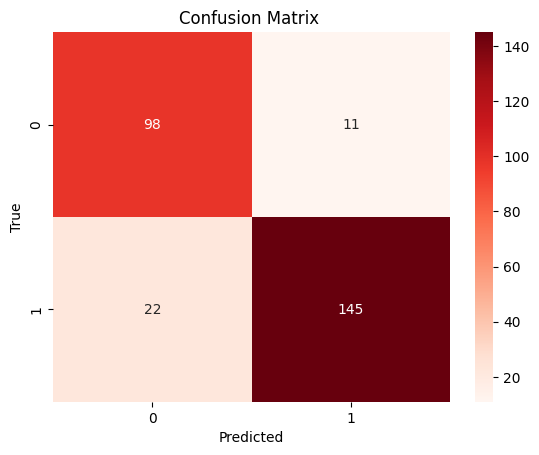



===============Classification Report===============


              precision    recall  f1-score   support

           0      0.817     0.899     0.856       109
           1      0.929     0.868     0.898       167

    accuracy                          0.880       276
   macro avg      0.873     0.884     0.877       276
weighted avg      0.885     0.880     0.881       276



In [36]:
cnf=conf_matrix_graph(X_test_scaled,Y_test, best_model)

In [37]:
logistic_summary=acc+cnf
logistic_summary

[0.8804347826086957,
 0.8629283489096573,
 0.9294871794871795,
 0.8682634730538922,
 0.8978328173374613]

# Decision Tree

In [38]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, Y_train)

DecisionTreeClassifier()

In [39]:
dt_model.score(X_train, Y_train)

1.0

In [40]:
dt_model.score(X_test, Y_test)

0.75

In [41]:
path = dt_model.cost_complexity_pruning_path(X_train, Y_train)
path
ccp_alpha = path.ccp_alphas
ccp_alpha

array([0.        , 0.0010156 , 0.00123186, 0.00124611, 0.00129803,
       0.00138456, 0.00138456, 0.00140187, 0.00144637, 0.00145379,
       0.00145379, 0.00146601, 0.00148305, 0.00149533, 0.00151578,
       0.00178015, 0.00188754, 0.00201391, 0.00207684, 0.00207684,
       0.00207684, 0.00233645, 0.00234017, 0.00237354, 0.00242298,
       0.00249221, 0.00259605, 0.00265949, 0.00267023, 0.002756  ,
       0.00280374, 0.00290042, 0.00291297, 0.0029626 , 0.00348096,
       0.00376068, 0.00380755, 0.00459365, 0.00460081, 0.00484044,
       0.00536433, 0.00595985, 0.00697819, 0.00726981, 0.00789747,
       0.00962244, 0.01402088, 0.0188805 , 0.04559316, 0.18637791])

In [42]:
dt_model2 = []
for ccp in ccp_alpha:
    dt_m  = DecisionTreeClassifier(ccp_alpha=ccp)
    dt_m.fit(X_train,Y_train)
    dt_model2.append(dt_m)

In [43]:
dt_model2

[DecisionTreeClassifier(),
 DecisionTreeClassifier(ccp_alpha=0.001015599146440268),
 DecisionTreeClassifier(ccp_alpha=0.0012318647085002247),
 DecisionTreeClassifier(ccp_alpha=0.0012461059190031149),
 DecisionTreeClassifier(ccp_alpha=0.0012980269989615785),
 DecisionTreeClassifier(ccp_alpha=0.0013845621322256835),
 DecisionTreeClassifier(ccp_alpha=0.0013845621322256835),
 DecisionTreeClassifier(ccp_alpha=0.001401869158878505),
 DecisionTreeClassifier(ccp_alpha=0.001446372941700045),
 DecisionTreeClassifier(ccp_alpha=0.0014537902388369682),
 DecisionTreeClassifier(ccp_alpha=0.0014537902388369682),
 DecisionTreeClassifier(ccp_alpha=0.001466006963533077),
 DecisionTreeClassifier(ccp_alpha=0.0014830518835859297),
 DecisionTreeClassifier(ccp_alpha=0.0014953271028037378),
 DecisionTreeClassifier(ccp_alpha=0.0015157840902664593),
 DecisionTreeClassifier(ccp_alpha=0.0017801513128615934),
 DecisionTreeClassifier(ccp_alpha=0.0018875371649709808),
 DecisionTreeClassifier(ccp_alpha=0.0020139085559

Text(0, 0.5, 'score')

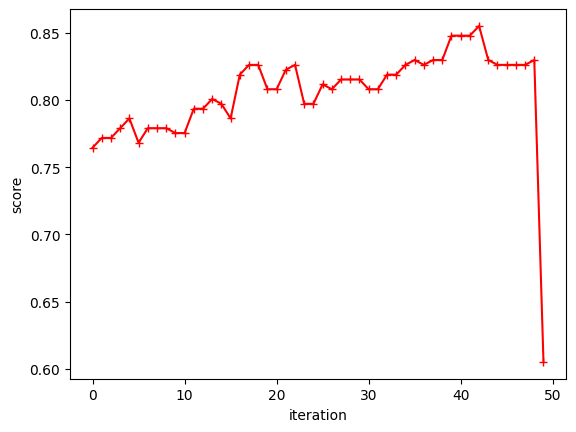

In [44]:
dt_model2 = []
score = []
for i in ccp_alpha:
    dt_m = DecisionTreeClassifier(ccp_alpha = i)
    dt_m.fit(X_train,Y_train)
    dt_model2.append(dt_m)
    score.append(dt_m.score(X_test, Y_test))

    
plt.plot(score, 'r-+')
plt.xlabel('iteration')
plt.ylabel('score')

In [45]:
train_score = [i.score(X_train,Y_train) for i in dt_model2]
test_score = [i.score(X_test ,Y_test) for i in dt_model2]

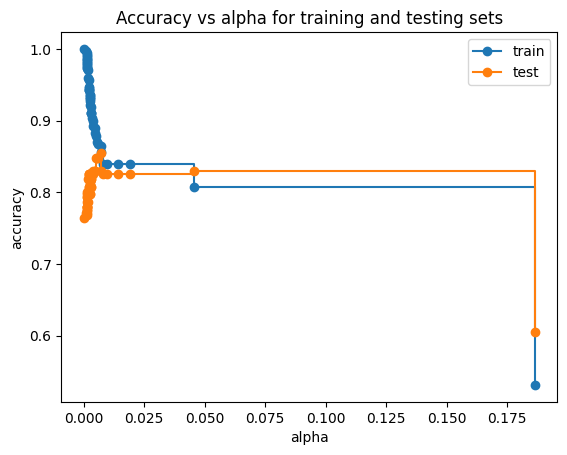

In [46]:
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alpha, train_score, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alpha, test_score, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [47]:
dt_with_ccp = DecisionTreeClassifier(random_state=0, ccp_alpha=0.007897469530524122)
dt_with_ccp.fit(X_train, Y_train)

DecisionTreeClassifier(ccp_alpha=0.007897469530524122, random_state=0)

In [48]:
acc_dec=print_accuracy(X_test,Y_test, X_train,Y_train,dt_with_ccp)

Accuracy test: 83.96%
Accuracy train: 82.61%


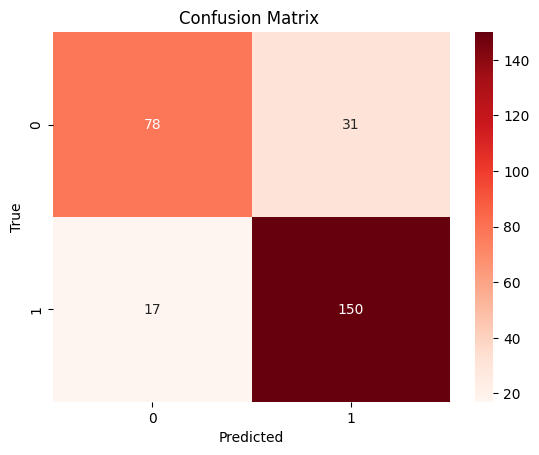



===============Classification Report===============


              precision    recall  f1-score   support

           0      0.821     0.716     0.765       109
           1      0.829     0.898     0.862       167

    accuracy                          0.826       276
   macro avg      0.825     0.807     0.813       276
weighted avg      0.826     0.826     0.824       276



In [49]:
cnf_dec=conf_matrix_graph(X_test, Y_test, dt_with_ccp)

In [50]:
dec_summary = acc_dec + cnf_dec
dec_summary

[0.839563862928349,
 0.8260869565217391,
 0.8287292817679558,
 0.8982035928143712,
 0.8620689655172413]

# RandomForest

In [51]:
rf = RandomForestClassifier(n_jobs=2, random_state=0)
rf.fit(X_train, Y_train)

RandomForestClassifier(n_jobs=2, random_state=0)

In [52]:
print_accuracy(X_train,Y_train, X_test, Y_test,rf)

Accuracy test: 88.77%
Accuracy train: 100.0%


[0.8876811594202898, 1.0]

In [53]:
rf1 = RandomForestClassifier(n_jobs=2, random_state=0)

In [54]:
rf1.fit(X_train_scaled,Y_train)

RandomForestClassifier(n_jobs=2, random_state=0)

In [55]:
print_accuracy(X_train_scaled,Y_train, X_test_scaled, Y_test,rf1)

Accuracy test: 88.04%
Accuracy train: 100.0%


[0.8804347826086957, 1.0]

### Using GridSearchCV

In [56]:
param_grid = [
{'n_estimators': [10, 25], 'max_features': [5, 10], 
 'max_depth': [10, 50, None], 'bootstrap': [True, False]}
]

grid_search_forest = GridSearchCV(rf1, param_grid, cv=10, scoring='neg_mean_squared_error')
grid_search_forest.fit(X_train_scaled, Y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(n_jobs=2, random_state=0),
             param_grid=[{'bootstrap': [True, False],
                          'max_depth': [10, 50, None], 'max_features': [5, 10],
                          'n_estimators': [10, 25]}],
             scoring='neg_mean_squared_error')

In [57]:
cvres = grid_search_forest.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.40436322209693526 {'bootstrap': True, 'max_depth': 10, 'max_features': 5, 'n_estimators': 10}
0.408267917313732 {'bootstrap': True, 'max_depth': 10, 'max_features': 5, 'n_estimators': 25}
0.41763988904686405 {'bootstrap': True, 'max_depth': 10, 'max_features': 10, 'n_estimators': 10}
0.3926610399666515 {'bootstrap': True, 'max_depth': 10, 'max_features': 10, 'n_estimators': 25}
0.4249151499009945 {'bootstrap': True, 'max_depth': 50, 'max_features': 5, 'n_estimators': 10}
0.40039043445117417 {'bootstrap': True, 'max_depth': 50, 'max_features': 5, 'n_estimators': 25}
0.408267917313732 {'bootstrap': True, 'max_depth': 50, 'max_features': 10, 'n_estimators': 10}
0.3946151971809422 {'bootstrap': True, 'max_depth': 50, 'max_features': 10, 'n_estimators': 25}
0.4249151499009945 {'bootstrap': True, 'max_depth': None, 'max_features': 5, 'n_estimators': 10}
0.40039043445117417 {'bootstrap': True, 'max_depth': None, 'max_features': 5, 'n_estimators': 25}
0.408267917313732 {'bootstrap': True, 'm

In [58]:
grid_search_forest.best_estimator_

RandomForestClassifier(max_depth=10, max_features=10, n_estimators=25, n_jobs=2,
                       random_state=0)

In [59]:
best_model=grid_search_forest.best_estimator_
rf_pred_gsc = best_model.predict(X_test_scaled)


In [60]:
print_accuracy(X_train_scaled,Y_train, X_test_scaled, Y_test,best_model)

Accuracy test: 85.51%
Accuracy train: 99.22%


[0.855072463768116, 0.9922118380062306]

### K-foldCV and cross validation

In [61]:
from sklearn.model_selection import cross_val_score

rf_kfoldcv = RandomForestClassifier(n_estimators=100, random_state=42)
cv_scores = cross_val_score(rf_kfoldcv, X, Y, cv=5, scoring='accuracy')
print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", cv_scores.mean())

Cross-Validation Scores: [0.89130435 0.82608696 0.82608696 0.83060109 0.7704918 ]
Mean Accuracy: 0.8289142314088858


In [62]:
final_rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
final_rf_model.fit(X_train_scaled, Y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

In [63]:
final_rf_model.score(X_test_scaled,Y_test)

0.8804347826086957

In [64]:
print_accuracy(X_train_scaled, Y_train, X_test_scaled, Y_test, final_rf_model)

Accuracy test: 88.04%
Accuracy train: 100.0%


[0.8804347826086957, 1.0]

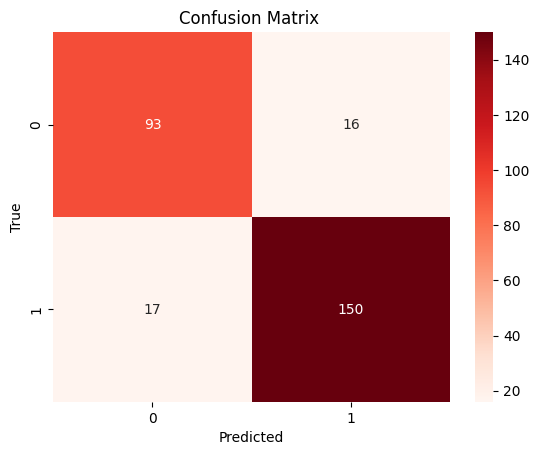



===============Classification Report===============


              precision    recall  f1-score   support

           0      0.845     0.853     0.849       109
           1      0.904     0.898     0.901       167

    accuracy                          0.880       276
   macro avg      0.875     0.876     0.875       276
weighted avg      0.881     0.880     0.881       276



[0.9036144578313253, 0.8982035928143712, 0.9009009009009009]

In [65]:
conf_matrix_graph(X_test_scaled,Y_test, final_rf_model)

In [66]:
from sklearn.model_selection import StratifiedKFold

In [67]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cnt = 1


# split()  method generate indices to split data into training and test set.
for train_index, test_index in kf.split(X, Y):
    print(f'Fold:{cnt}, Train set: {len(train_index)}, Test set:{len(test_index)}')
    cnt+=1


Fold:1, Train set: 734, Test set:184
Fold:2, Train set: 734, Test set:184
Fold:3, Train set: 734, Test set:184
Fold:4, Train set: 735, Test set:183
Fold:5, Train set: 735, Test set:183


In [68]:
score = cross_val_score(ensemble.RandomForestClassifier(random_state= 42), X, Y, cv= kf, scoring="accuracy")
print(f'Scores for each fold are: {score}')
print(f'Average score: {"{:.2f}".format(score.mean())}')

Scores for each fold are: [0.90217391 0.875      0.83152174 0.8852459  0.80874317]
Average score: 0.86


### RandomizedSearchCv

In [69]:
from sklearn.model_selection import RandomizedSearchCV

rsc = RandomForestClassifier()
param_dist = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=rsc,
    param_distributions=param_dist,
    n_iter=10,  # Number of parameter settings that are sampled
    cv=5,      # Number of cross-validation folds
    scoring='accuracy',
    random_state=42
)

random_search.fit(X_train_scaled, Y_train)
best_params = random_search.best_params_
best_model = random_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'n_estimators': 50, 'max_features': 'log2', 'max_depth': 20, 'bootstrap': True}


In [70]:
y_pred=best_model.predict(X_test_scaled)
accuracy_rscv = accuracy_score(Y_test,y_pred)
accuracy_rscv

0.8804347826086957

In [71]:
acc_randf=print_accuracy(X_train_scaled, Y_train, X_test_scaled, Y_test,best_model)

Accuracy test: 88.04%
Accuracy train: 99.84%


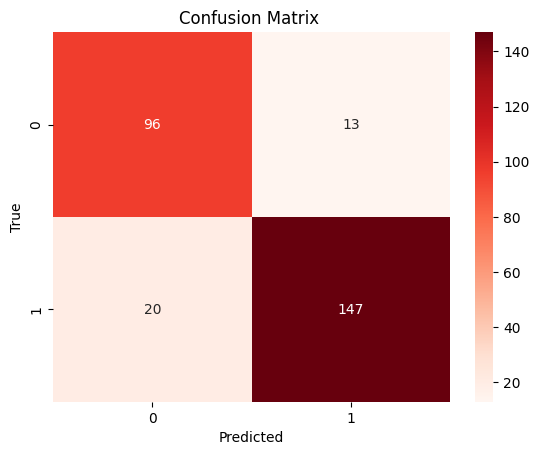



===============Classification Report===============


              precision    recall  f1-score   support

           0      0.828     0.881     0.853       109
           1      0.919     0.880     0.899       167

    accuracy                          0.880       276
   macro avg      0.873     0.880     0.876       276
weighted avg      0.883     0.880     0.881       276



In [72]:
cnf_randf=conf_matrix_graph(X_test_scaled,Y_test, best_model)

In [73]:
randf_summary = acc_randf + cnf_randf
randf_summary

[0.8804347826086957,
 0.9984423676012462,
 0.91875,
 0.8802395209580839,
 0.8990825688073394]

# KNN 

In [74]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import scale
from sklearn import metrics as sm
from sklearn.metrics import classification_report, precision_score

In [75]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_scaled, Y_train)

KNeighborsClassifier(n_neighbors=3)

In [76]:
knn.predict(X_test_scaled)

array([1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0])

In [77]:
acc_knn=print_accuracy(X_train_scaled, Y_train, X_test_scaled, Y_test, knn)

Accuracy test: 85.51%
Accuracy train: 90.03%


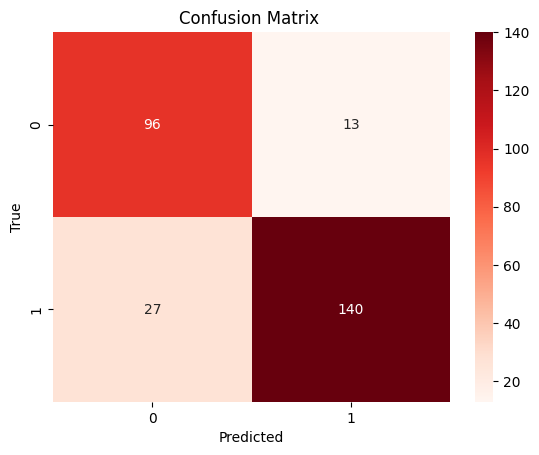



===============Classification Report===============


              precision    recall  f1-score   support

           0      0.780     0.881     0.828       109
           1      0.915     0.838     0.875       167

    accuracy                          0.855       276
   macro avg      0.848     0.860     0.851       276
weighted avg      0.862     0.855     0.856       276



In [78]:
cnf_knn=conf_matrix_graph(X_test_scaled,Y_test,knn)

In [79]:
knn_summary = acc_knn + cnf_knn
knn_summary

[0.855072463768116,
 0.9003115264797508,
 0.9150326797385621,
 0.8383233532934131,
 0.875]

In [80]:

# Define the parameter grid with different values of k 
param_grid = {'n_neighbors': [1, 3, 5, 7, 9]} 
# Create KNN classifier 
knn_classifier = KNeighborsClassifier() 
# Perform grid search with cross-validation
grid_search = GridSearchCV(knn_classifier, param_grid, cv=5, scoring='accuracy') 
grid_search.fit(X_train_scaled, Y_train) 
# Get the best value of k 
best_k = grid_search.best_params_['n_neighbors'] 
print("Best value of k:", best_k)

Best value of k: 5


In [81]:
best_model_knn= grid_search.best_estimator_
best_model_knn.fit(X_train_scaled, Y_train)

KNeighborsClassifier()

In [82]:
acc_knn=print_accuracy(X_train_scaled, Y_train, X_test_scaled, Y_test, best_model_knn)

Accuracy test: 85.87%
Accuracy train: 88.79%


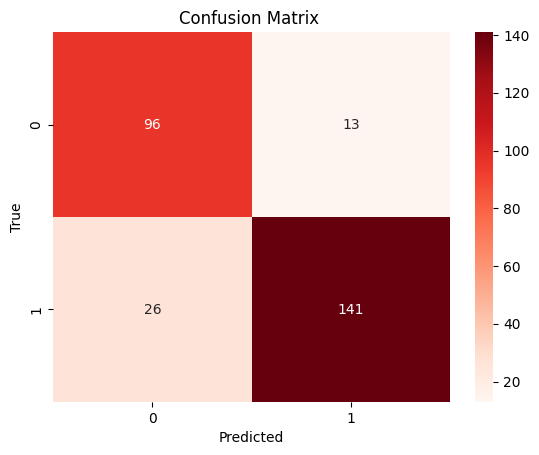



===============Classification Report===============


              precision    recall  f1-score   support

           0      0.787     0.881     0.831       109
           1      0.916     0.844     0.879       167

    accuracy                          0.859       276
   macro avg      0.851     0.863     0.855       276
weighted avg      0.865     0.859     0.860       276



In [83]:
cnf_knn=conf_matrix_graph(X_test_scaled, Y_test, best_model_knn)

In [84]:
knn_summary = acc_knn + cnf_knn
knn_summary

[0.8586956521739131,
 0.8878504672897196,
 0.9155844155844156,
 0.844311377245509,
 0.8785046728971964]

# SVM

In [85]:
svc = SVC(random_state=42, kernel='rbf')
svc.fit(X_train_scaled, Y_train)

SVC(random_state=42)

In [86]:
acc_svm=print_accuracy(X_train_scaled, Y_train, X_test_scaled, Y_test, svc)

Accuracy test: 88.77%
Accuracy train: 91.12%


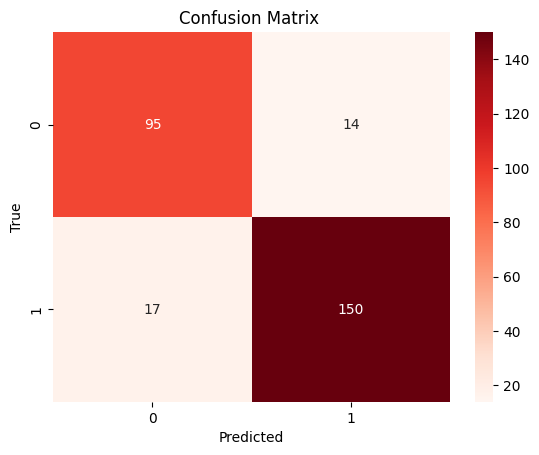



===============Classification Report===============


              precision    recall  f1-score   support

           0      0.848     0.872     0.860       109
           1      0.915     0.898     0.906       167

    accuracy                          0.888       276
   macro avg      0.881     0.885     0.883       276
weighted avg      0.888     0.888     0.888       276



In [87]:
cnf_svm=conf_matrix_graph(X_test_scaled, Y_test, svc)

In [88]:
svm_summary = acc_svm + cnf_svm
svm_summary

[0.8876811594202898,
 0.9112149532710281,
 0.9146341463414634,
 0.8982035928143712,
 0.9063444108761329]

# XGBoost

In [89]:
xgb= XGBClassifier(random_state=42)
xgb.fit(X_train_scaled, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [90]:
acc_xgboost=print_accuracy(X_train_scaled, Y_train, X_test_scaled, Y_test, xgb)

Accuracy test: 67.03%
Accuracy train: 100.0%


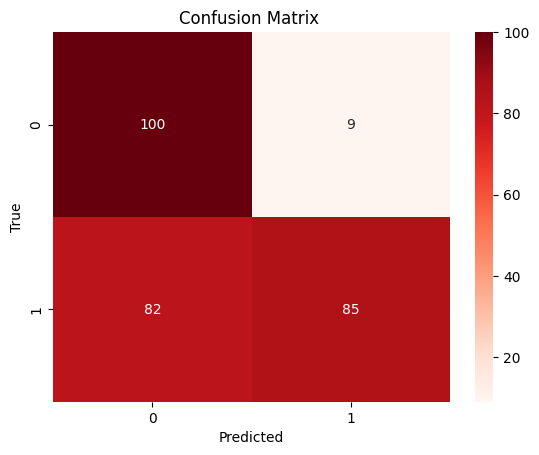



===============Classification Report===============


              precision    recall  f1-score   support

           0      0.549     0.917     0.687       109
           1      0.904     0.509     0.651       167

    accuracy                          0.670       276
   macro avg      0.727     0.713     0.669       276
weighted avg      0.764     0.670     0.666       276



In [91]:
cnf_xgboost=conf_matrix_graph(X_test_scaled, Y_test, xgb)

In [92]:
xgboost_summary = acc_xgboost + cnf_xgboost
xgboost_summary

[0.6702898550724637,
 1.0,
 0.9042553191489362,
 0.5089820359281437,
 0.6513409961685824]

# Naive Bayes

In [93]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, Y_train)

GaussianNB()

In [94]:
acc_nb=print_accuracy(X_train_scaled, Y_train, X_test_scaled, Y_test, gnb)

Accuracy test: 82.61%
Accuracy train: 79.91%


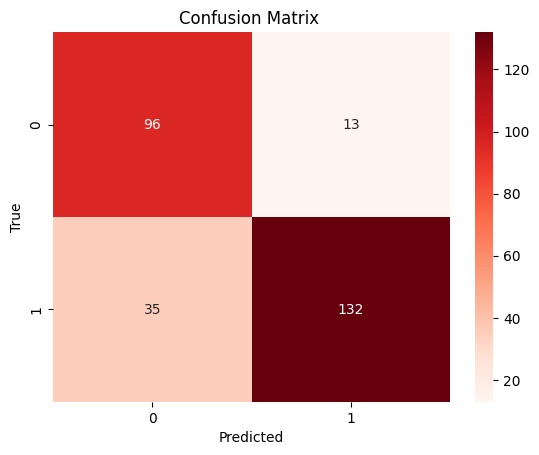



===============Classification Report===============


              precision    recall  f1-score   support

           0      0.733     0.881     0.800       109
           1      0.910     0.790     0.846       167

    accuracy                          0.826       276
   macro avg      0.822     0.836     0.823       276
weighted avg      0.840     0.826     0.828       276



In [95]:
cnf_nb=nb_conf_mat=conf_matrix_graph(X_test_scaled, Y_test, gnb)

In [96]:
nb_summary = acc_nb + cnf_nb
nb_summary

[0.8260869565217391,
 0.7990654205607477,
 0.9103448275862069,
 0.7904191616766467,
 0.8461538461538463]

# Summary

In [97]:
models=pd.DataFrame({
   'Logistic Regression':logistic_summary,
    'Decision Tree' : dec_summary,
    'Random Forest' : randf_summary,
    'knn' : knn_summary,
    'svm' : svm_summary,
    'XG-Boost': xgboost_summary,
    'Naive Bayes': nb_summary

})
column_mapping = {0: 'Accuracy test', 1: 'Accuracy train', 2: 'cost possitive',3:'cost negatives',4:'mean cost P and cost N'}
result=models.T.rename(columns=column_mapping)

In [98]:
result

Accuracy test  Accuracy train  cost possitive  \
Logistic Regression       0.880435        0.862928        0.929487   
Decision Tree             0.839564        0.826087        0.828729   
Random Forest             0.880435        0.998442        0.918750   
knn                       0.858696        0.887850        0.915584   
svm                       0.887681        0.911215        0.914634   
XG-Boost                  0.670290        1.000000        0.904255   
Naive Bayes               0.826087        0.799065        0.910345   

                     cost negatives  mean cost P and cost N  
Logistic Regression        0.868263                0.897833  
Decision Tree              0.898204                0.862069  
Random Forest              0.880240                0.899083  
knn                        0.844311                0.878505  
svm                        0.898204                0.906344  
XG-Boost                   0.508982                0.651341  
Naive Bayes                0.790419                0.846154